The purpose of the smoother is to smooth complex sequences, such as those observed in reported COVID-19 cases that is challenging for traditional smoothers features such as quasi-periodicity and large permutations that result from batched counts. We developed a smoother that is resilient to such noise regimes while still being flexible and simple to use, allowing users to encode their beliefs about system dynamics by manipulating only one mandatory hyper parameter.

In [1]:
import sys
sys.path.insert(1, 'C:/Users/Udara/Documents/GRACE/src')
import VASmoother as VAS
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from matplotlib.pyplot import figure
from scipy.stats import chisquare

In [2]:
def simple_moving_average(a,n=3):
    m = int(n/2)
    MA = []
    for i in range(0,len(a)):
        pl = i-m
        ph=i+m
        if(pl < 0):
            pl = 0
        if(ph > len(a)-1):
            ph = len(a)-1
        MA.append(np.average(a[pl:ph+1]))
    return np.array(MA)

The CSV file owid-covid-data.csv contains COVID 19 daily reported new cases and deaths. Upload the CSV file into a data frame and read India's daily reported deaths into a NumPy array. 

In [3]:
data_df = pd.read_csv('owid-covid-data.csv')  
India = data_df.loc[data_df['location'] == 'India']
India = India.dropna(subset=['date', 'new_deaths'])
#Following NumPy array contains daily reported deaths
India_death_array = India['new_deaths'].to_numpy()
#Following NumPy array contains dates
India_dates = India['date'].to_numpy()

Following graph visualize the daily reported new death data in India. 

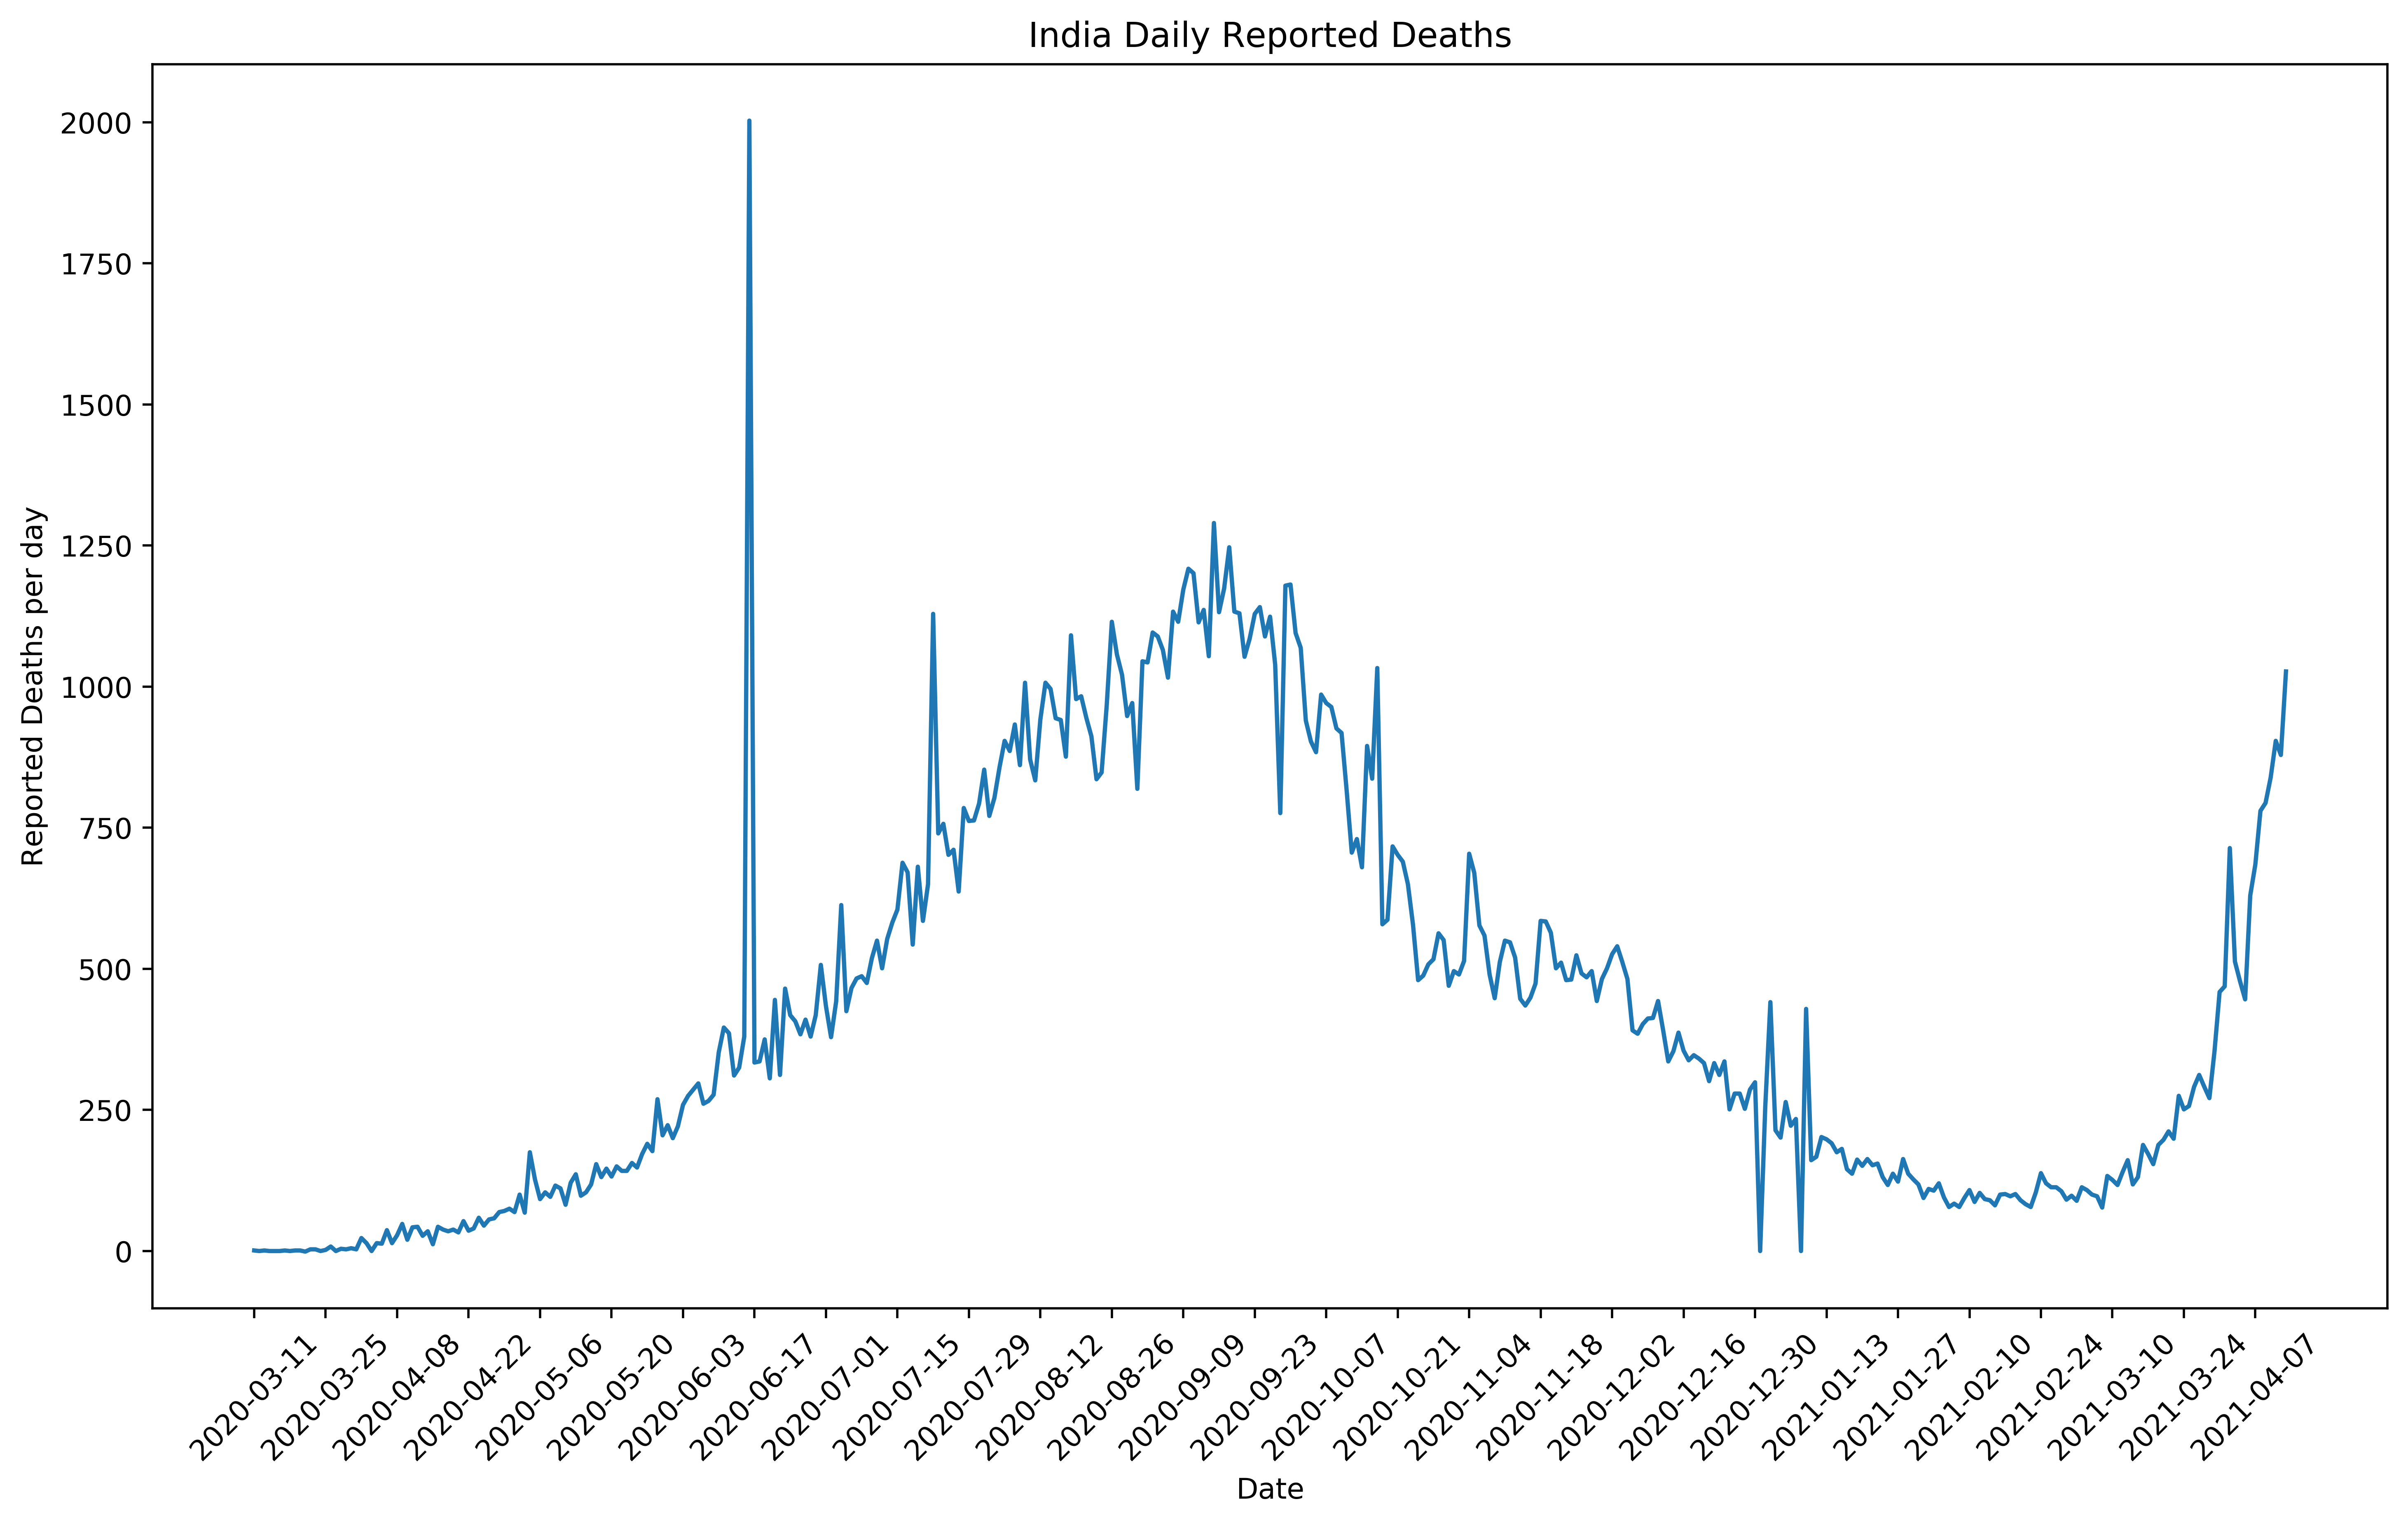

In [4]:
figure(figsize=(14, 8),dpi=500)
plt.plot(India_dates,India_death_array)
ax = plt.gca()
plt.xticks(rotation = 45)
plt.title('India Daily Reported Deaths')
plt.xlabel('Date')
plt.ylabel('Reported Deaths per day')
ax.set_xticks(ax.get_xticks()[::14]);

One typical noise that we observed with COVID 19 data is sudden spikes. For example, there are two spikes in India's reported death cases that are shown above. One is on 2020-06-16, and the other is on 2020-07-22. 

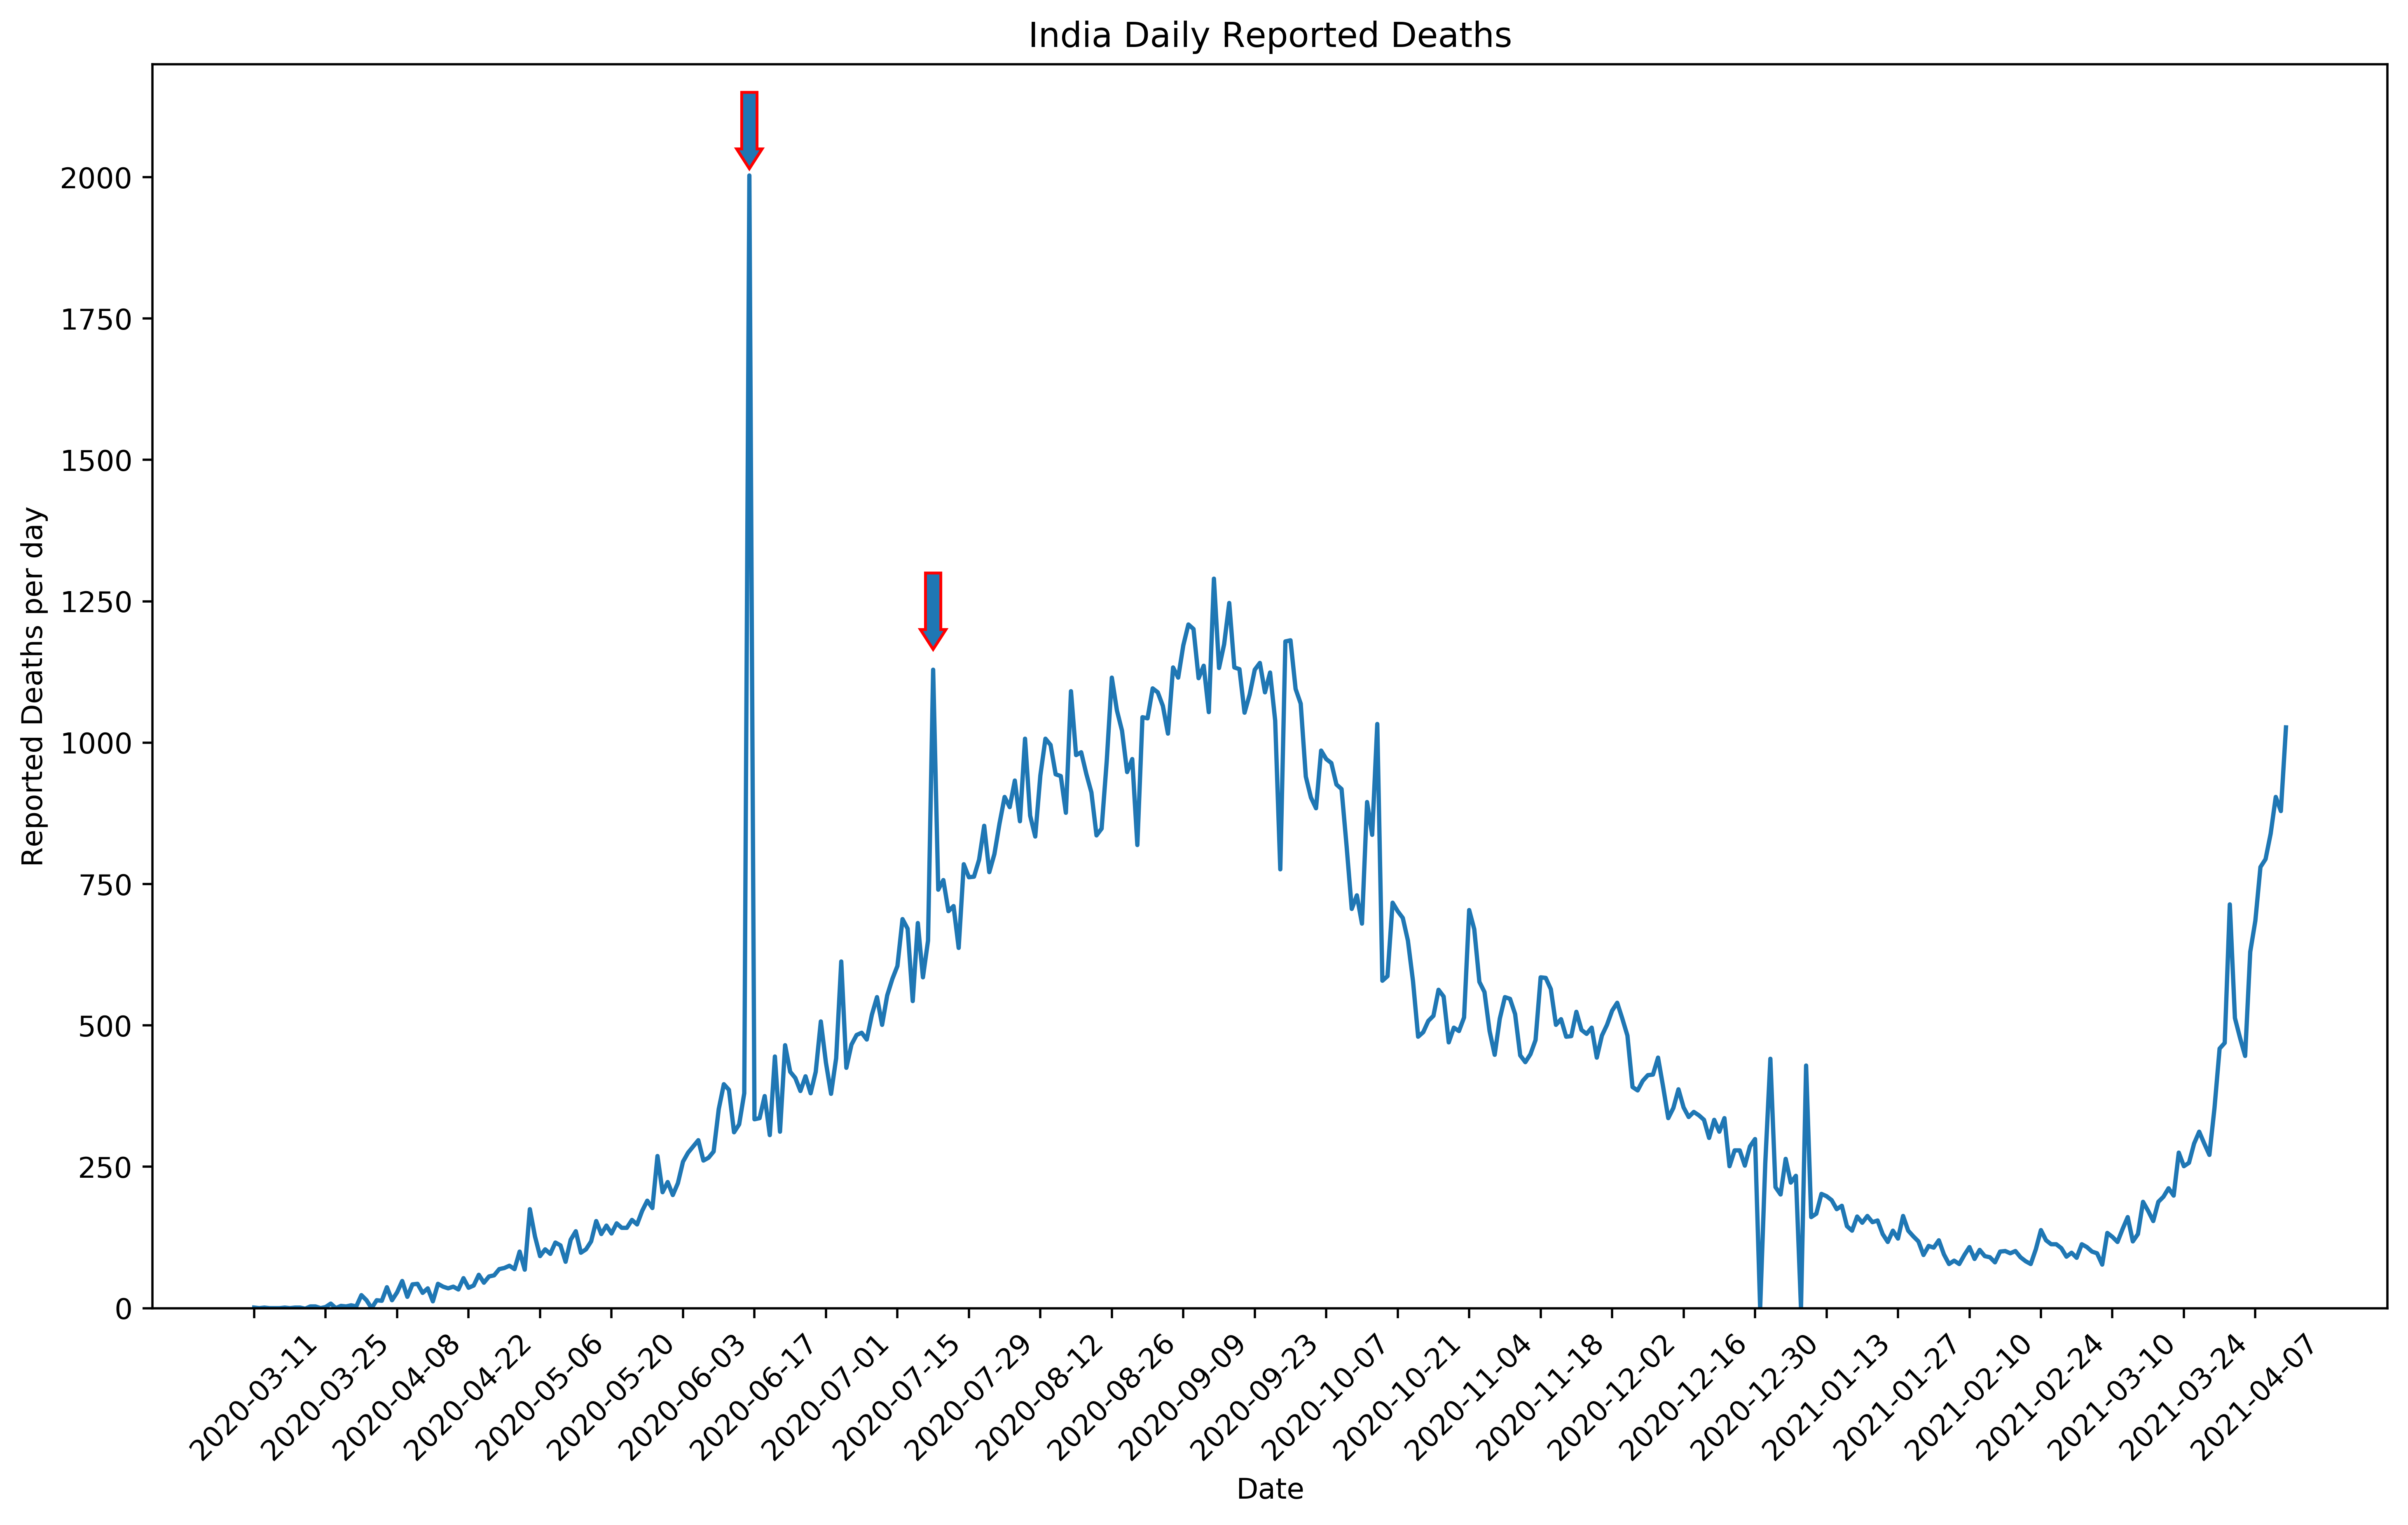

In [5]:
figure(figsize=(14, 8),dpi=500)
plt.ylim((0, 2200))
plt.plot(India_dates,India_death_array)
plt.arrow(97, 2150, 0, -100, width = 3,head_width = 5, head_length= 35, ec ='red')
plt.arrow(133,1300, 0, -100, width = 3,head_width = 5, head_length= 35,ec ='red')

ax = plt.gca()
plt.xticks(rotation = 45)
plt.title('India Daily Reported Deaths')
plt.xlabel('Date')
plt.ylabel('Reported Deaths per day')
ax.set_xticks(ax.get_xticks()[::14]);

plt.savefig('IndiaDeathCases.png')

Imagine that we are on 2020-06-16. What we observe is a sudden uptick in data. The common practice to remove these noises is to smooth data with a seven-day Simple Moving Average (SMA).  The following graph shows the raw data and smoothed data when the raw data is smoothed with seven-day SMA. 


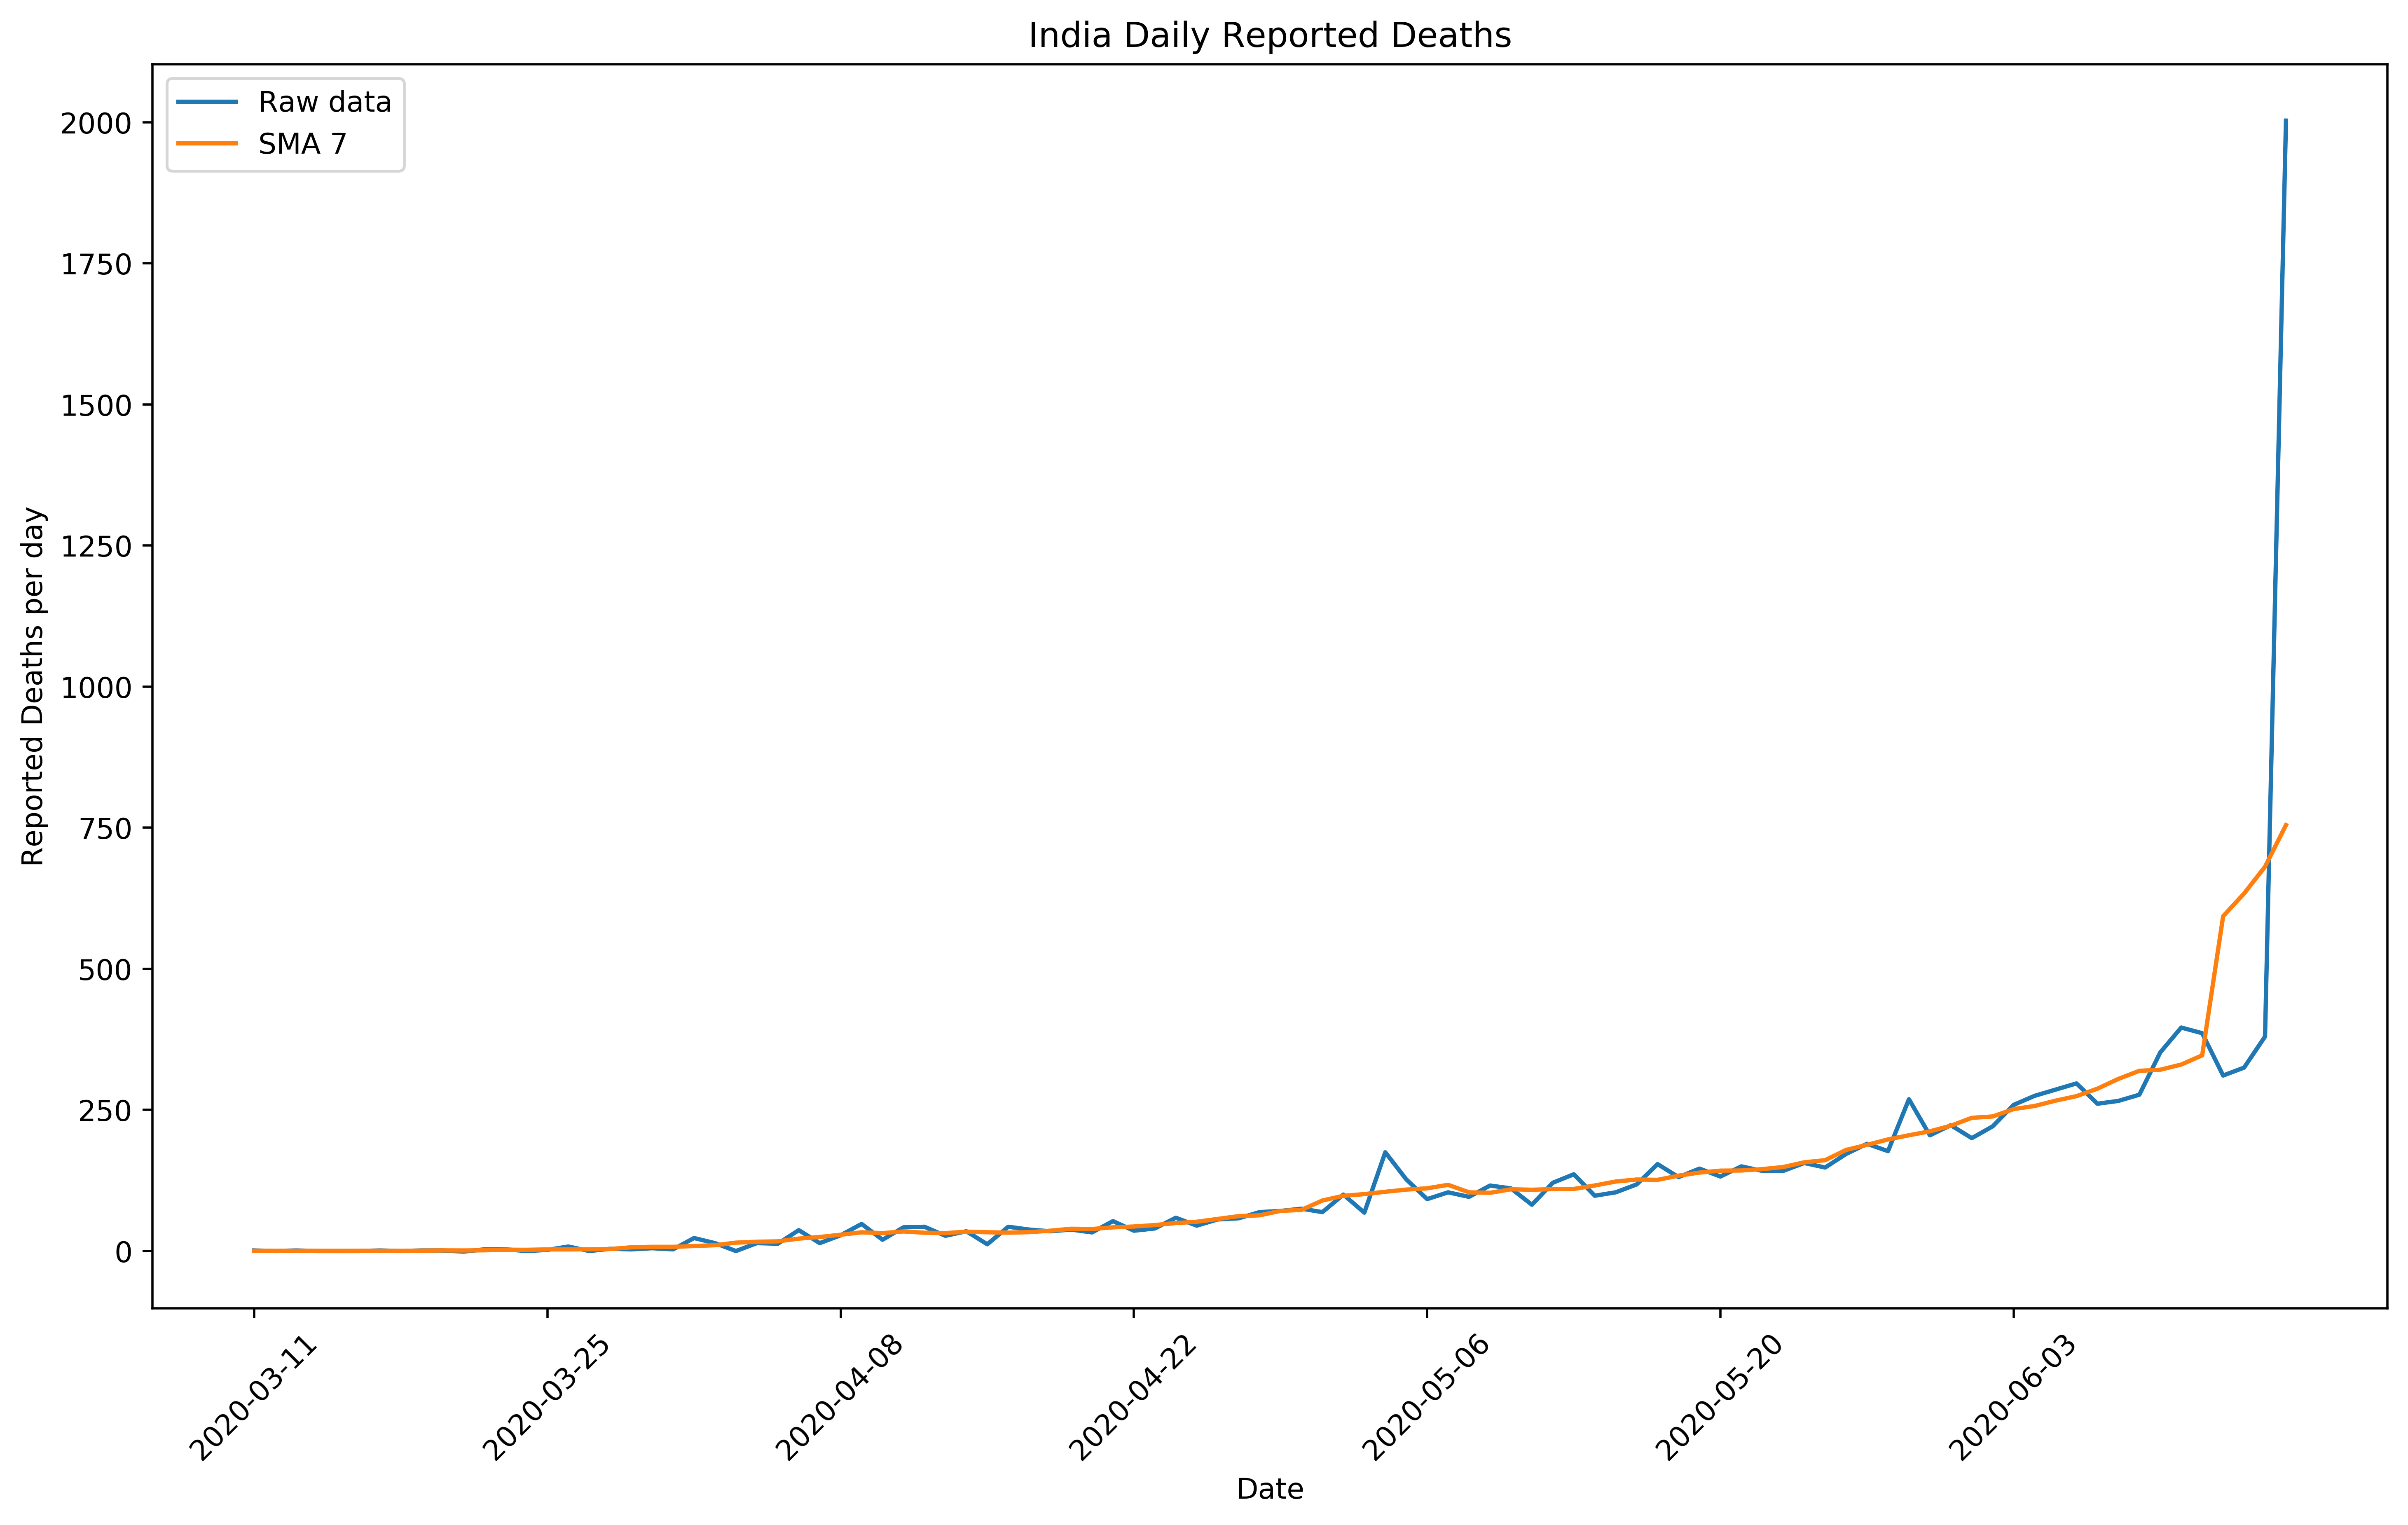

In [6]:
India_short_death = India_death_array[:98]
India_short_time = India_dates[:98]

India_short_death_7 = simple_moving_average(India_short_death,7)


figure(figsize=(14, 8),dpi=500)

plt.plot(India_short_time,India_short_death,label='Raw data');
plt.plot(India_short_time,India_short_death_7,label='SMA 7')

plt.legend()
ax = plt.gca()
plt.xticks(rotation = 45)
plt.title('India Daily Reported Deaths')
plt.xlabel('Date')
plt.ylabel('Reported Deaths per day')
ax.set_xticks(ax.get_xticks()[::14]);
plt.savefig('UptickSMASmoothed.png')

Notice in the above graph that the seven-day SMA is reacting to the sudden uptick. However, when you saw the complete data, you have seen that this uptick is a noise. Therefore, a better smoother should not react to such sudden upticks. So, let us take a look at how the VA smoother reacts to this uptick. 

In [7]:
#First, you create an object of the smoother.
Smoother_Object_2 = VAS.VASmoother()

#The next step is to set the only mandatory hyperparameter of our smoother package.
#This hyper parameter decised the smoothness of the output.
#Smaller values makes the output smoother.
#Refer our paper to understand how to select this value.
#Smoother will automatically smooth the time series until the desired smoothness is achieved. 
Smoother_Object_2.curvature_threshold_1 = 0.0006
#Sometimes there are segments on time series where the curvature is very high. 
#If we try to smooth the curve, including those sections, the other sections of the time series become over-smoothed. 
#Our algorithm can automatically identify those sections. 
#The following function identifies those sections and returns the indexes to include and exclude into index_included and index_excluded, respectively.
index_included, index_excluded = Smoother_Object_2.seperate_outlier_curvatures(India_short_death, 21, 1, 0)
#Now we run our smoother with the index_included identified by the above function. 
kz_window,kz_itr,smoothed_curve_short,curvature_arr,smoothing_mods = Smoother_Object_2.run_va_smoother(India_short_death,0,index_included)



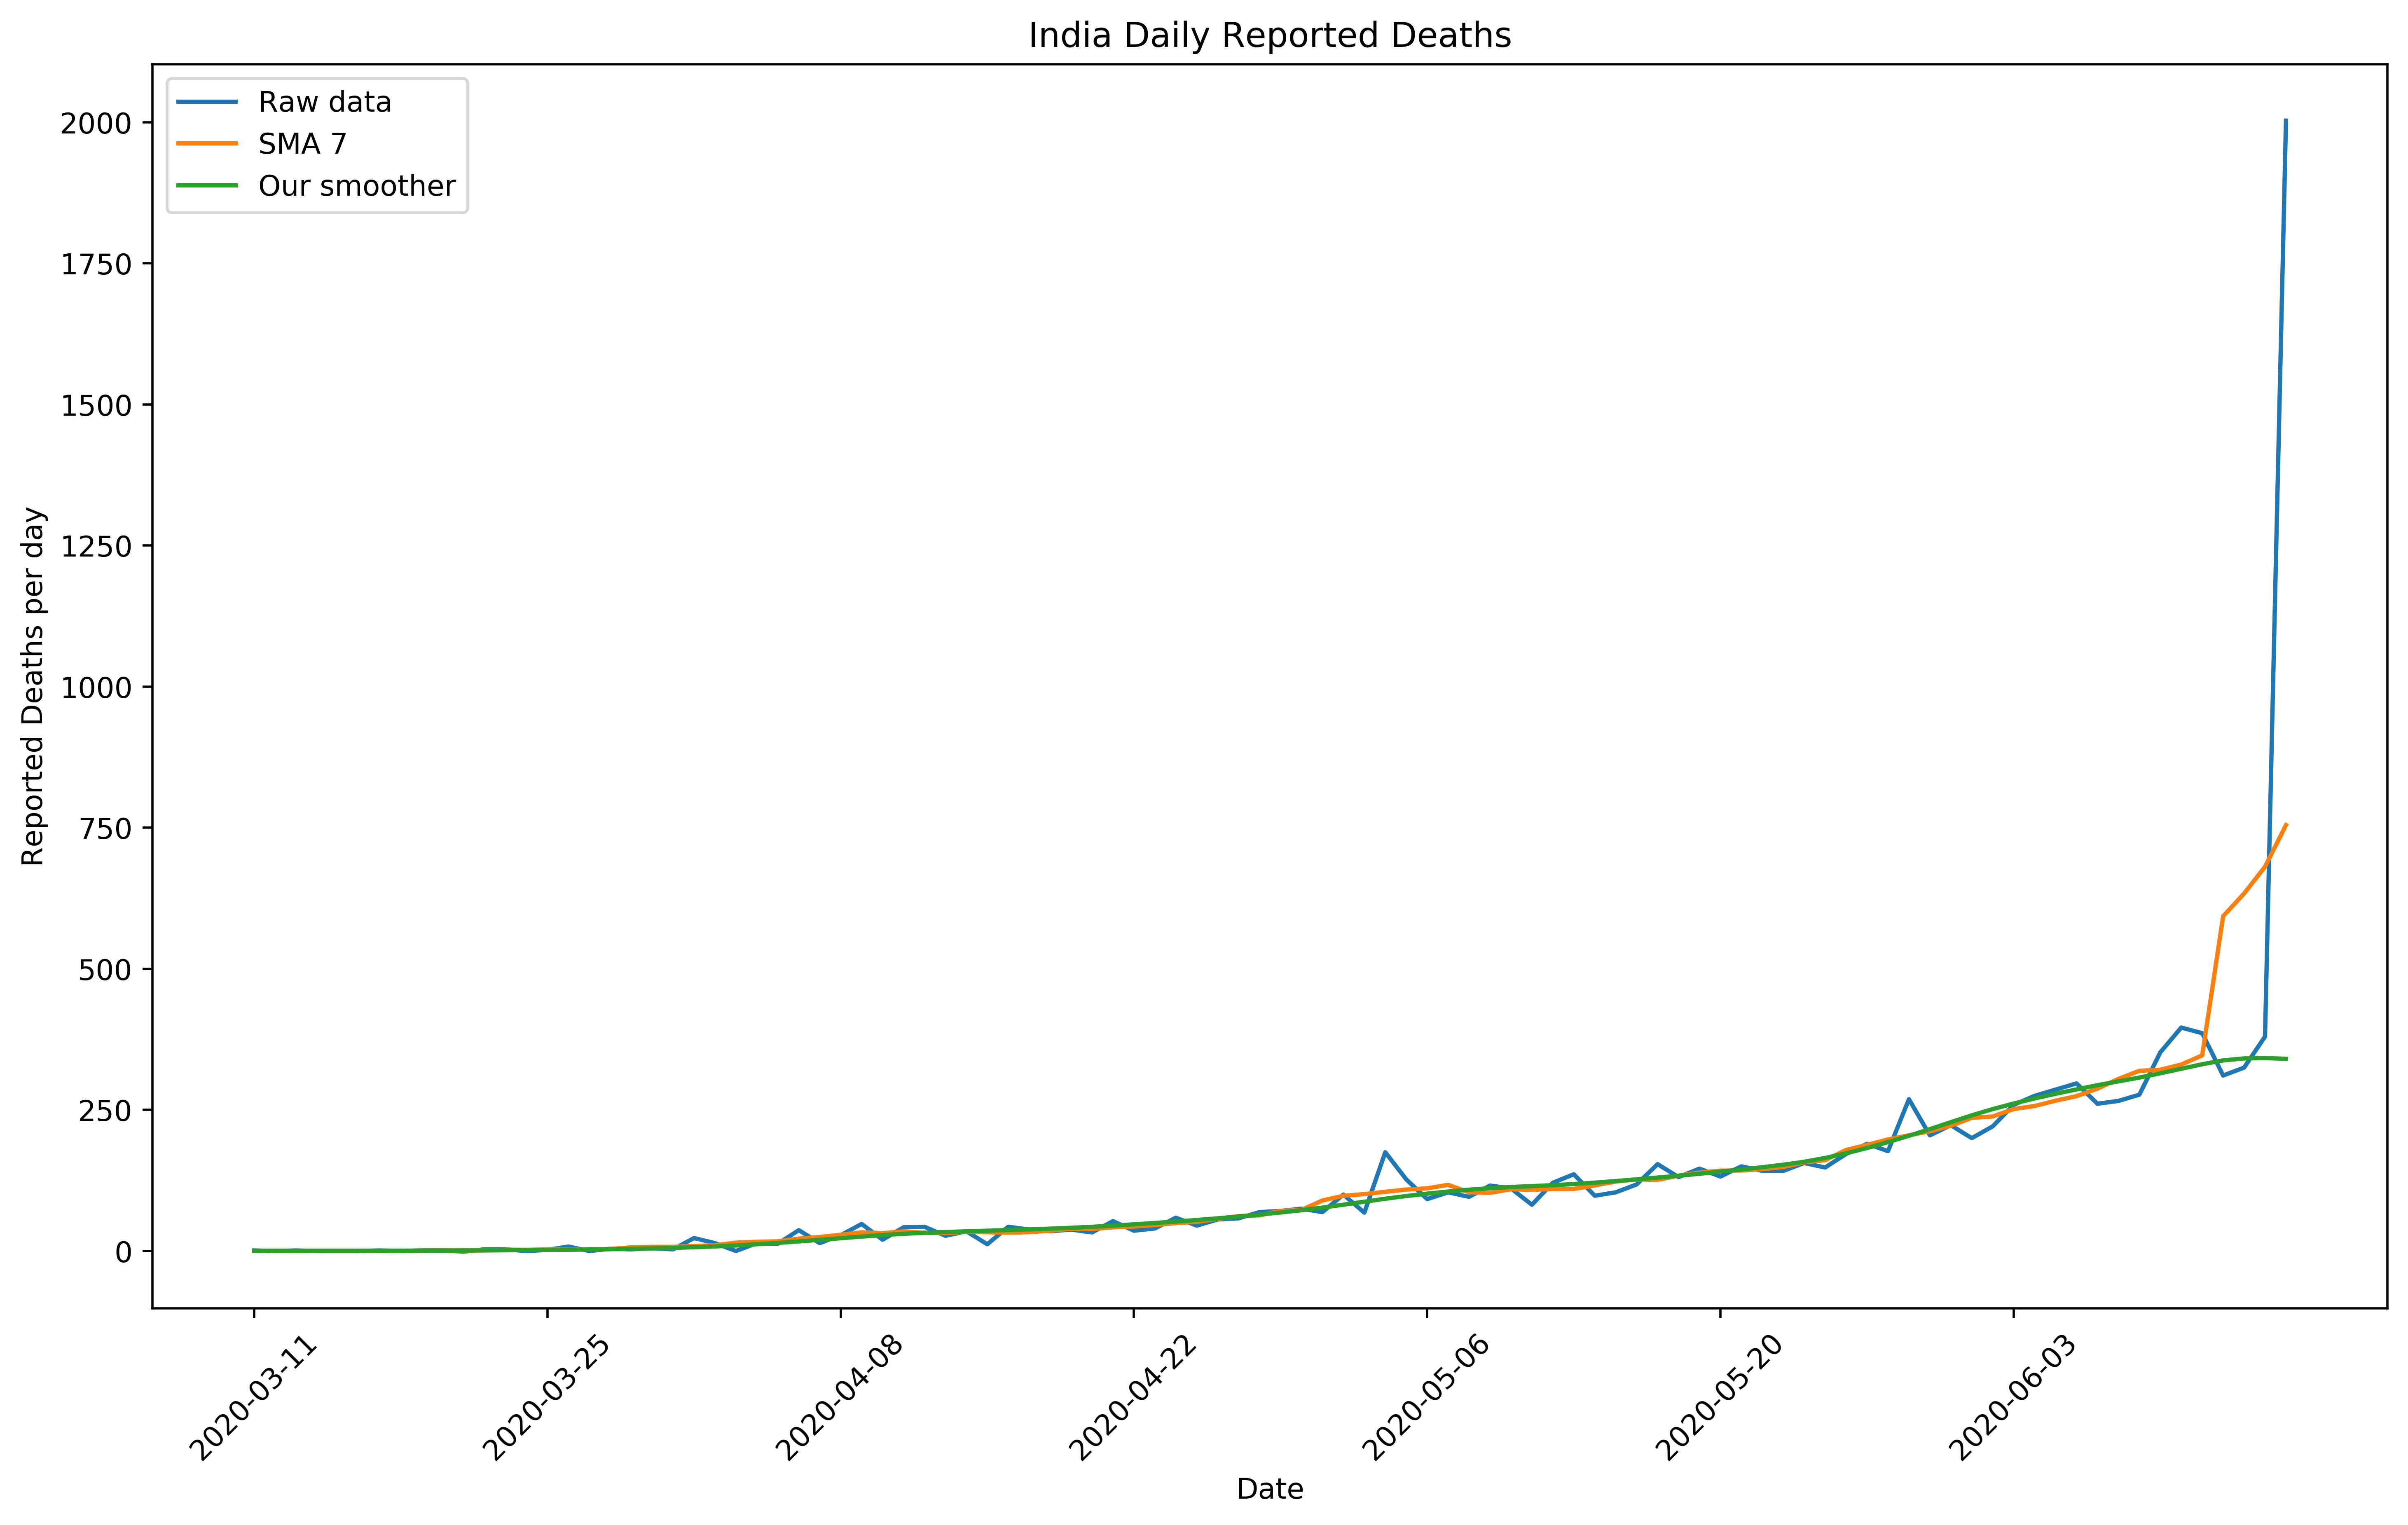

In [8]:
figure(figsize=(14, 8),dpi=500)

plt.plot(India_short_time,India_short_death,label='Raw data');
plt.plot(India_short_time,India_short_death_7, label='SMA 7')
plt.plot(India_short_time,smoothed_curve_short,label='Our smoother')

plt.legend()
ax = plt.gca()
plt.xticks(rotation = 45)
plt.title('India Daily Reported Deaths')
plt.xlabel('Date')
plt.ylabel('Reported Deaths per day')
ax.set_xticks(ax.get_xticks()[::14]);
plt.savefig('UptickSMA_AND_VA_Smoothed.png')

You can see that the VA smoother is not reacting to a sudden uptick. Instead, it smoothly continues. Next, let us investigate how seven-day SMA and VA smoother responds to this type of uptick when the upticks are in the time series, not at the end.  

In [9]:
#First, you create an object of the smoother.
Smoother_Object = VAS.VASmoother()

#The next step is to set the only mandatory hyperparameter of our smoother package.
#This hyper parameter decised the smoothness of the output.
#Smaller values makes the output smoother.
#Refer our paper to understand how to select this value.
#Smoother will automatically smooth the time series until the desired smoothness is achieved. 
Smoother_Object.curvature_threshold_1 = 0.00006
#Sometimes there are segments on time series where the curvature is very high. 
#If we try to smooth the curve, including those sections, the other sections of the time series become over-smoothed. 
#Our algorithm can automatically identify those sections. 
#The following function identifies those sections and returns the indexes to include and exclude into index_included and index_excluded, respectively.
index_included, index_excluded = Smoother_Object.seperate_outlier_curvatures(India_death_array, 21, 1, 0)
#Now we run our smoother with the index_included identified by the above function. 
kz_window,kz_itr,smoothed_curve,curvature_arr,smoothing_mods = Smoother_Object.run_va_smoother(India_death_array,0,index_included)


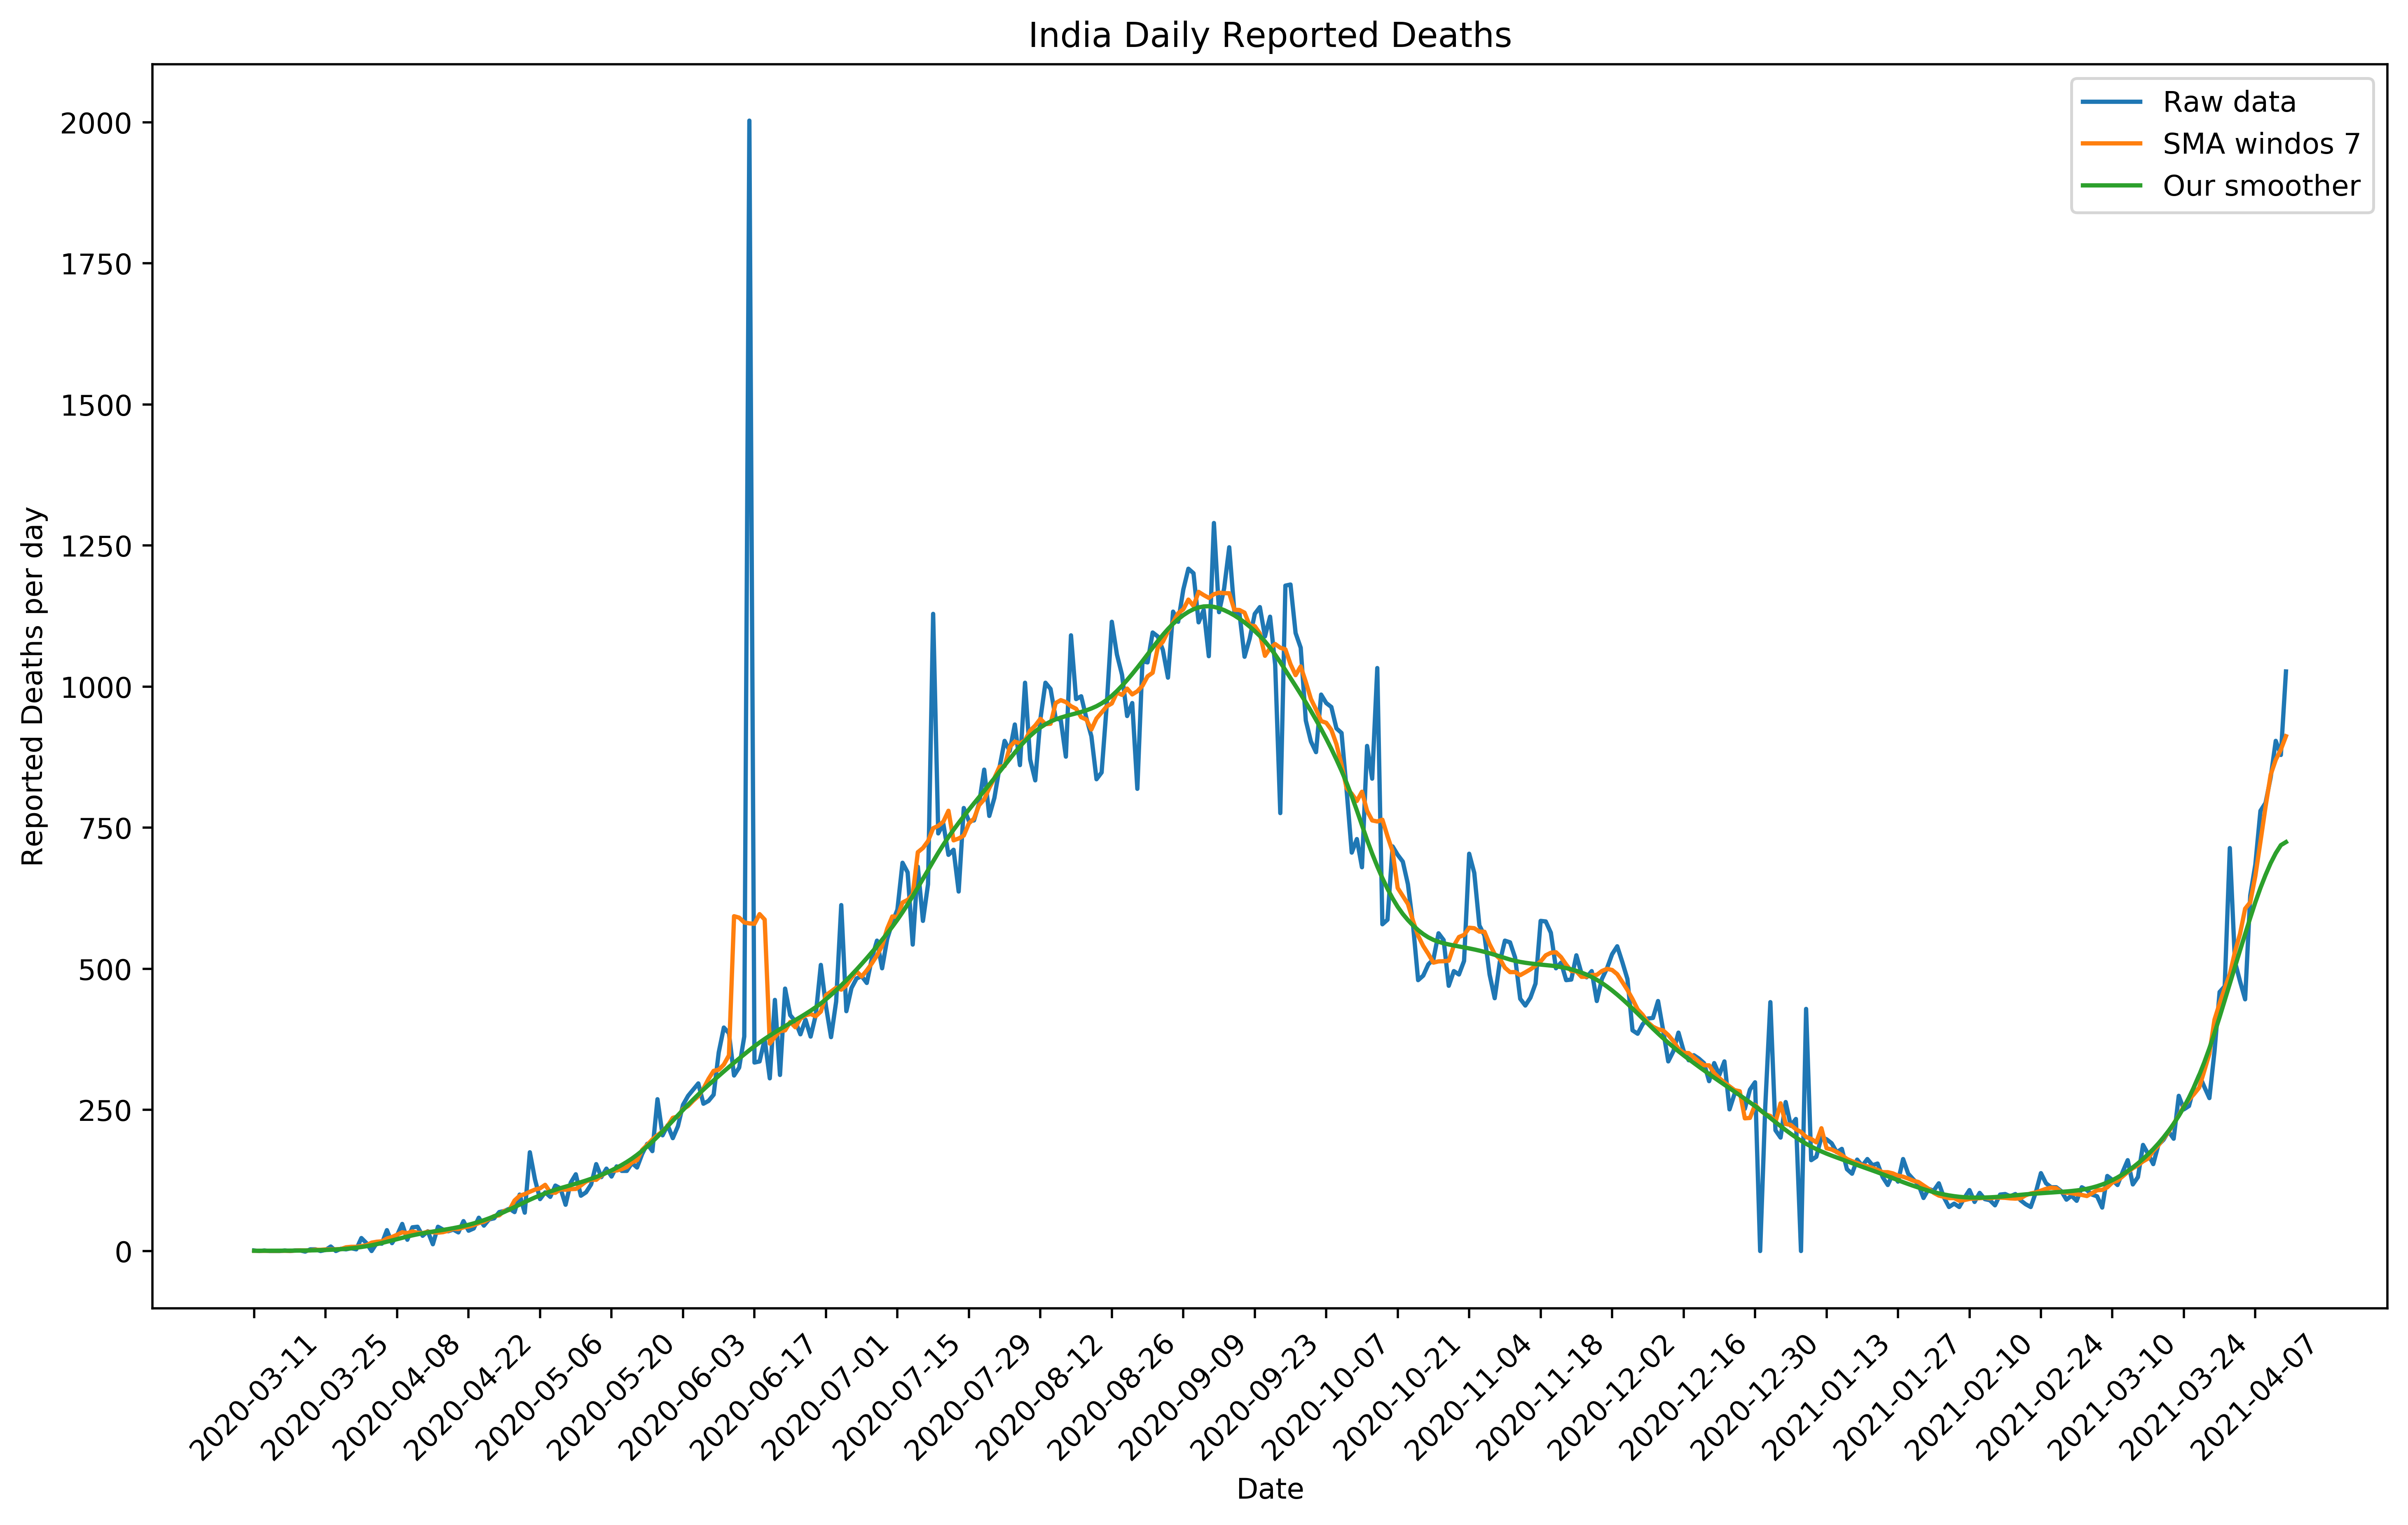

In [10]:
India_death_array_7 = simple_moving_average(India_death_array,7)


figure(figsize=(14, 8),dpi=500)

plt.plot(India_dates,India_death_array,label='Raw data')
plt.plot(India_dates,India_death_array_7,label='SMA windos 7')
plt.plot(India_dates,smoothed_curve,label='Our smoother')

plt.legend()
ax = plt.gca()
plt.xticks(rotation = 45)
plt.title('India Daily Reported Deaths')
plt.xlabel('Date')
plt.ylabel('Reported Deaths per day')
ax.set_xticks(ax.get_xticks()[::14]);
plt.savefig('EntireCurve_SMA_VA_Smoothed.png')

One could see that the SMA smoothed curve created a square wave shape part at the place where there are spikes in the raw data. The accuracy of the forecasting algorithms significantly decays when we have this type of artifact in the smoothed curves. In the above case, this artifact is evident because the noise level is high. However, artifacts created by a lower level of noise that causes lowering forecasting accuracy are more common. The output of the VA smoother is shown in a light green line. VA smoother is not responding to the spikes, and the smoothed curve continues the trend. 

Another common type of noise is consecutive two spikes. One goes up, and the subsequent spike goes down or vice versa. India's reported death data has this type of noise between 2021-01-02 and 2021-12-31. There is an uptick on 2021-01-02 and a down tick on 2021-12-31. Similar noise is visible between 2021-01-08 and 2021-01-10. 

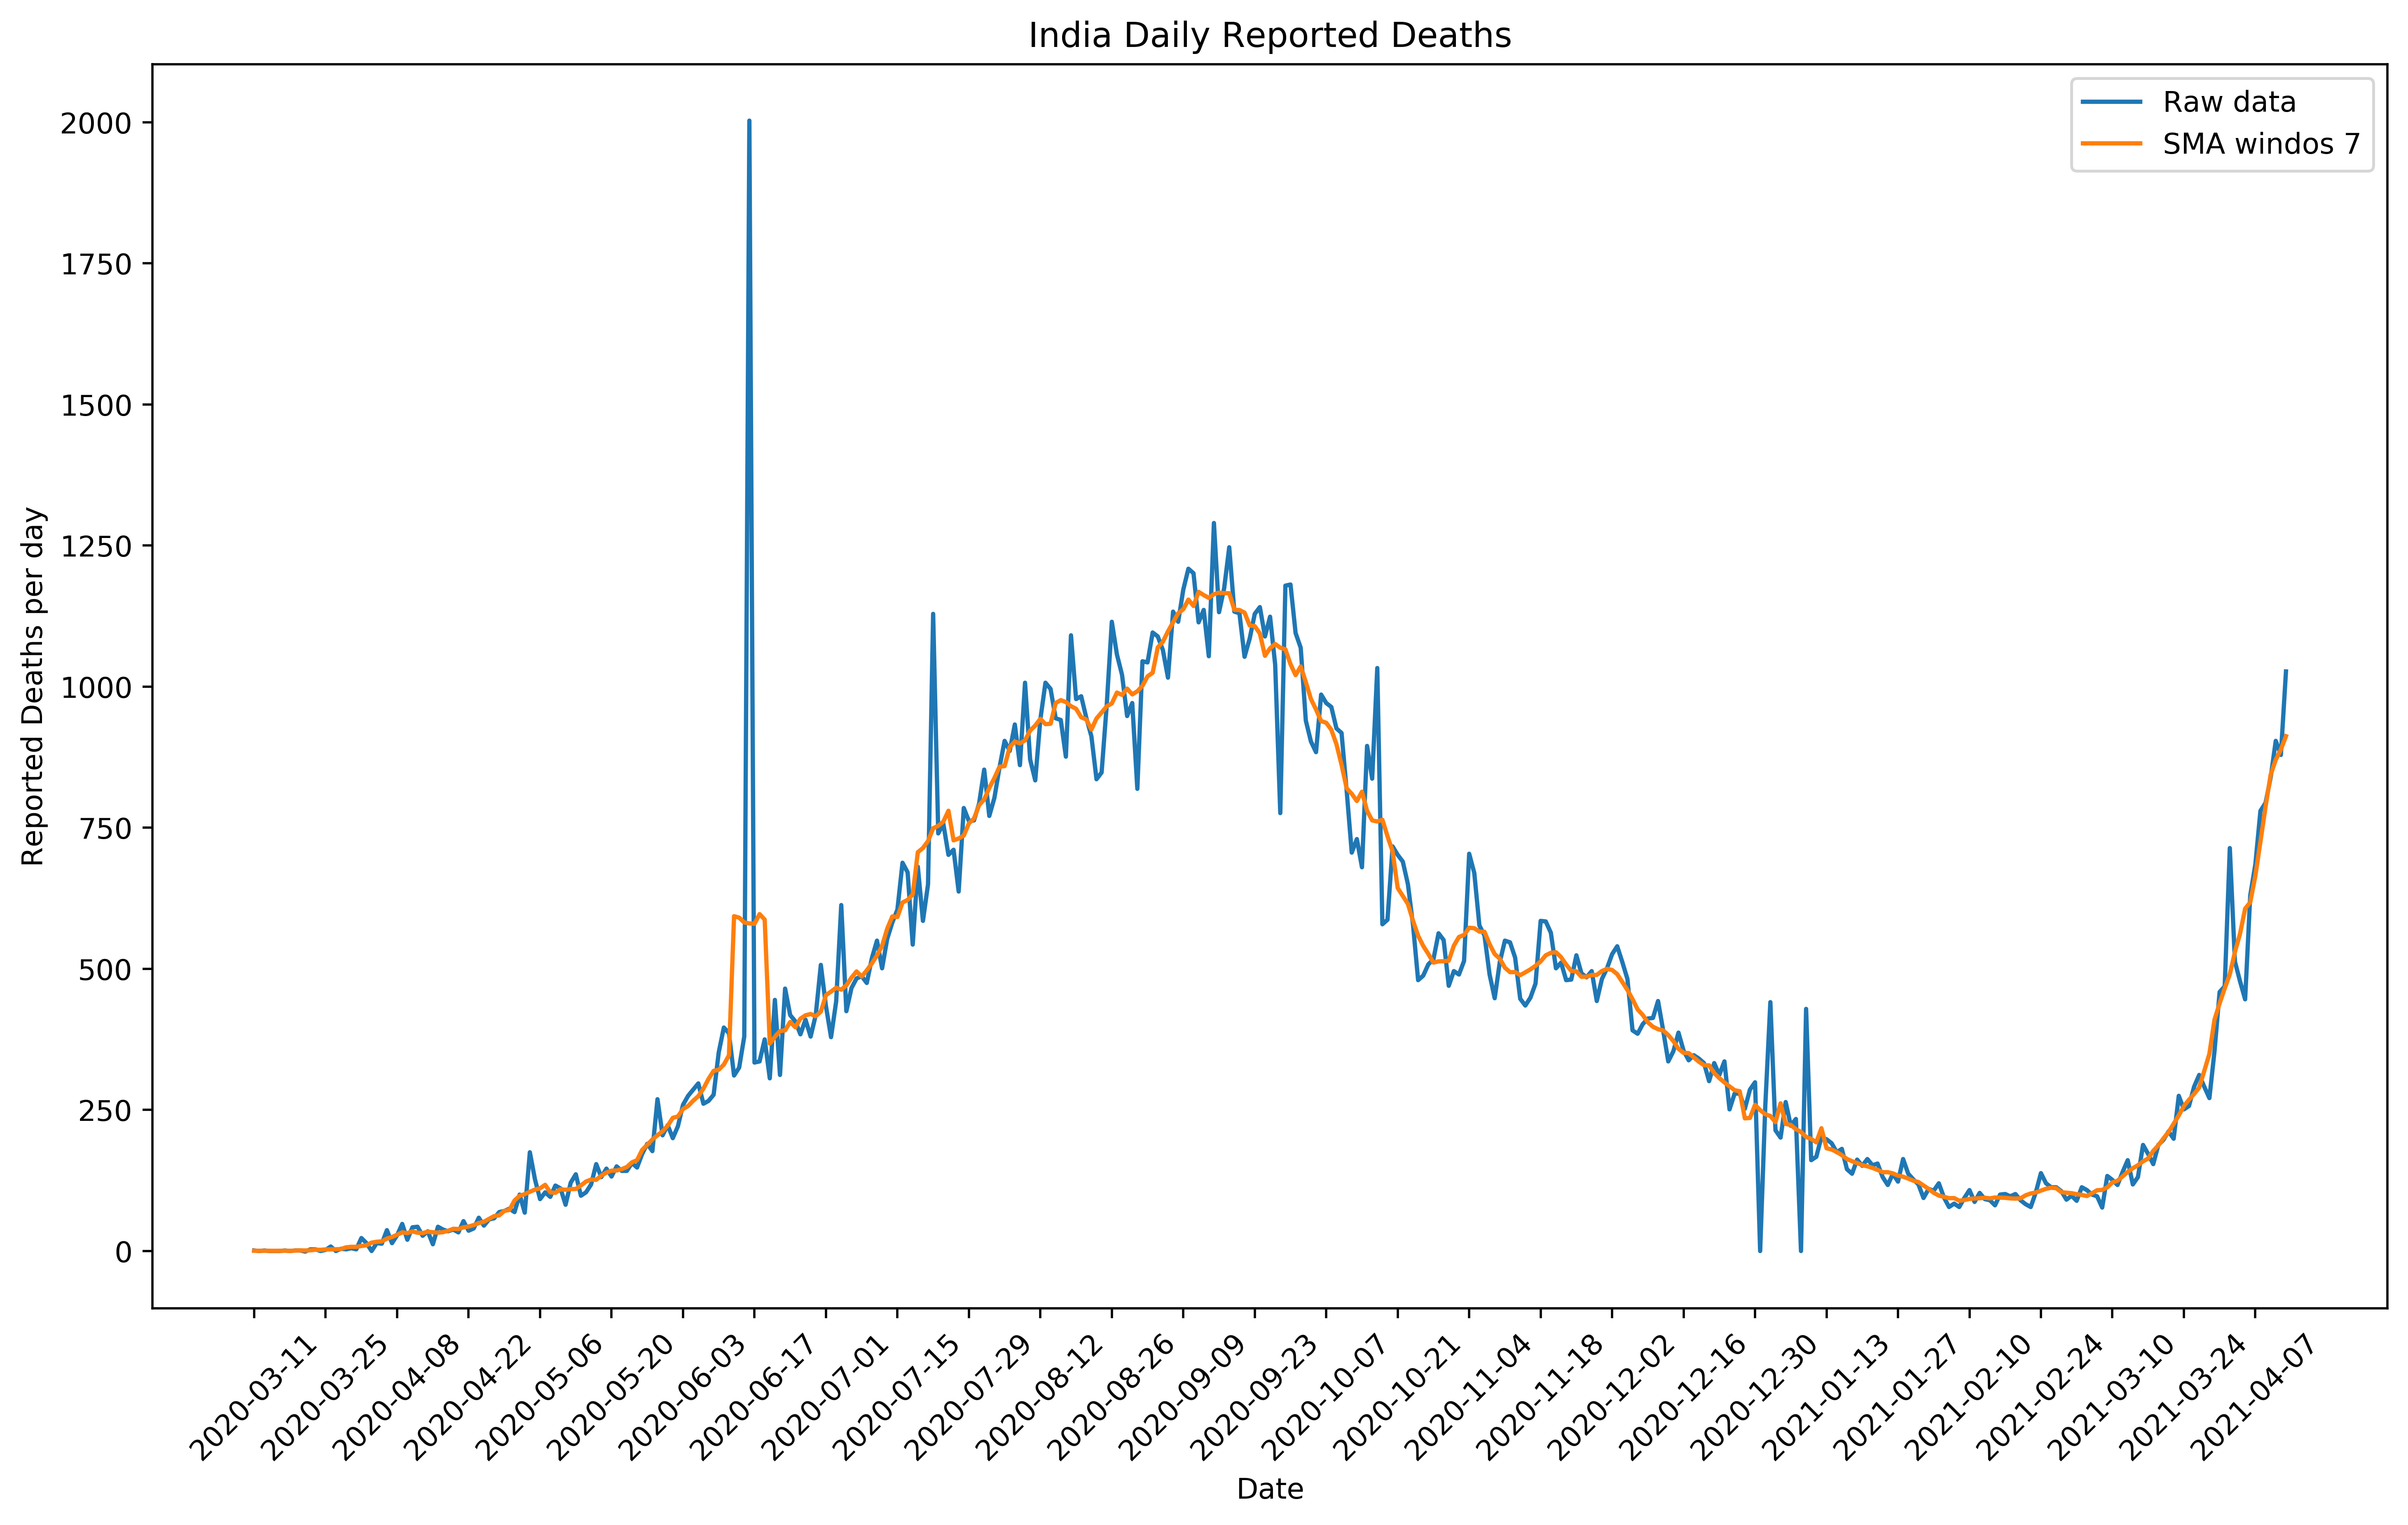

In [11]:
figure(figsize=(14, 8),dpi=500)

plt.plot(India_dates,India_death_array,label='Raw data')
plt.plot(India_dates,India_death_array_7,label='SMA windos 7')
#plt.plot(India_dates,smoothed_curve,label='Our smoother')

#plt.arrow(295, 610, 0, -100, width = 1,head_width = 2, head_length= 35, ec ='red')
#plt.arrow(297,610, 0, -100, width = 1,head_width = 2, head_length= 35,ec ='red')

#plt.arrow(303, 610, 0, -100, width = 1,head_width = 2, head_length= 35, ec ='red')
#plt.arrow(305,610, 0, -100, width = 1,head_width = 2, head_length= 35,ec ='red')

plt.legend()
ax = plt.gca()
plt.xticks(rotation = 45)
plt.title('India Daily Reported Deaths')
plt.xlabel('Date')
plt.ylabel('Reported Deaths per day')
ax.set_xticks(ax.get_xticks()[::14]);
plt.savefig('IndiaSMA.png')

The following graph shows a closer look at this time window. 

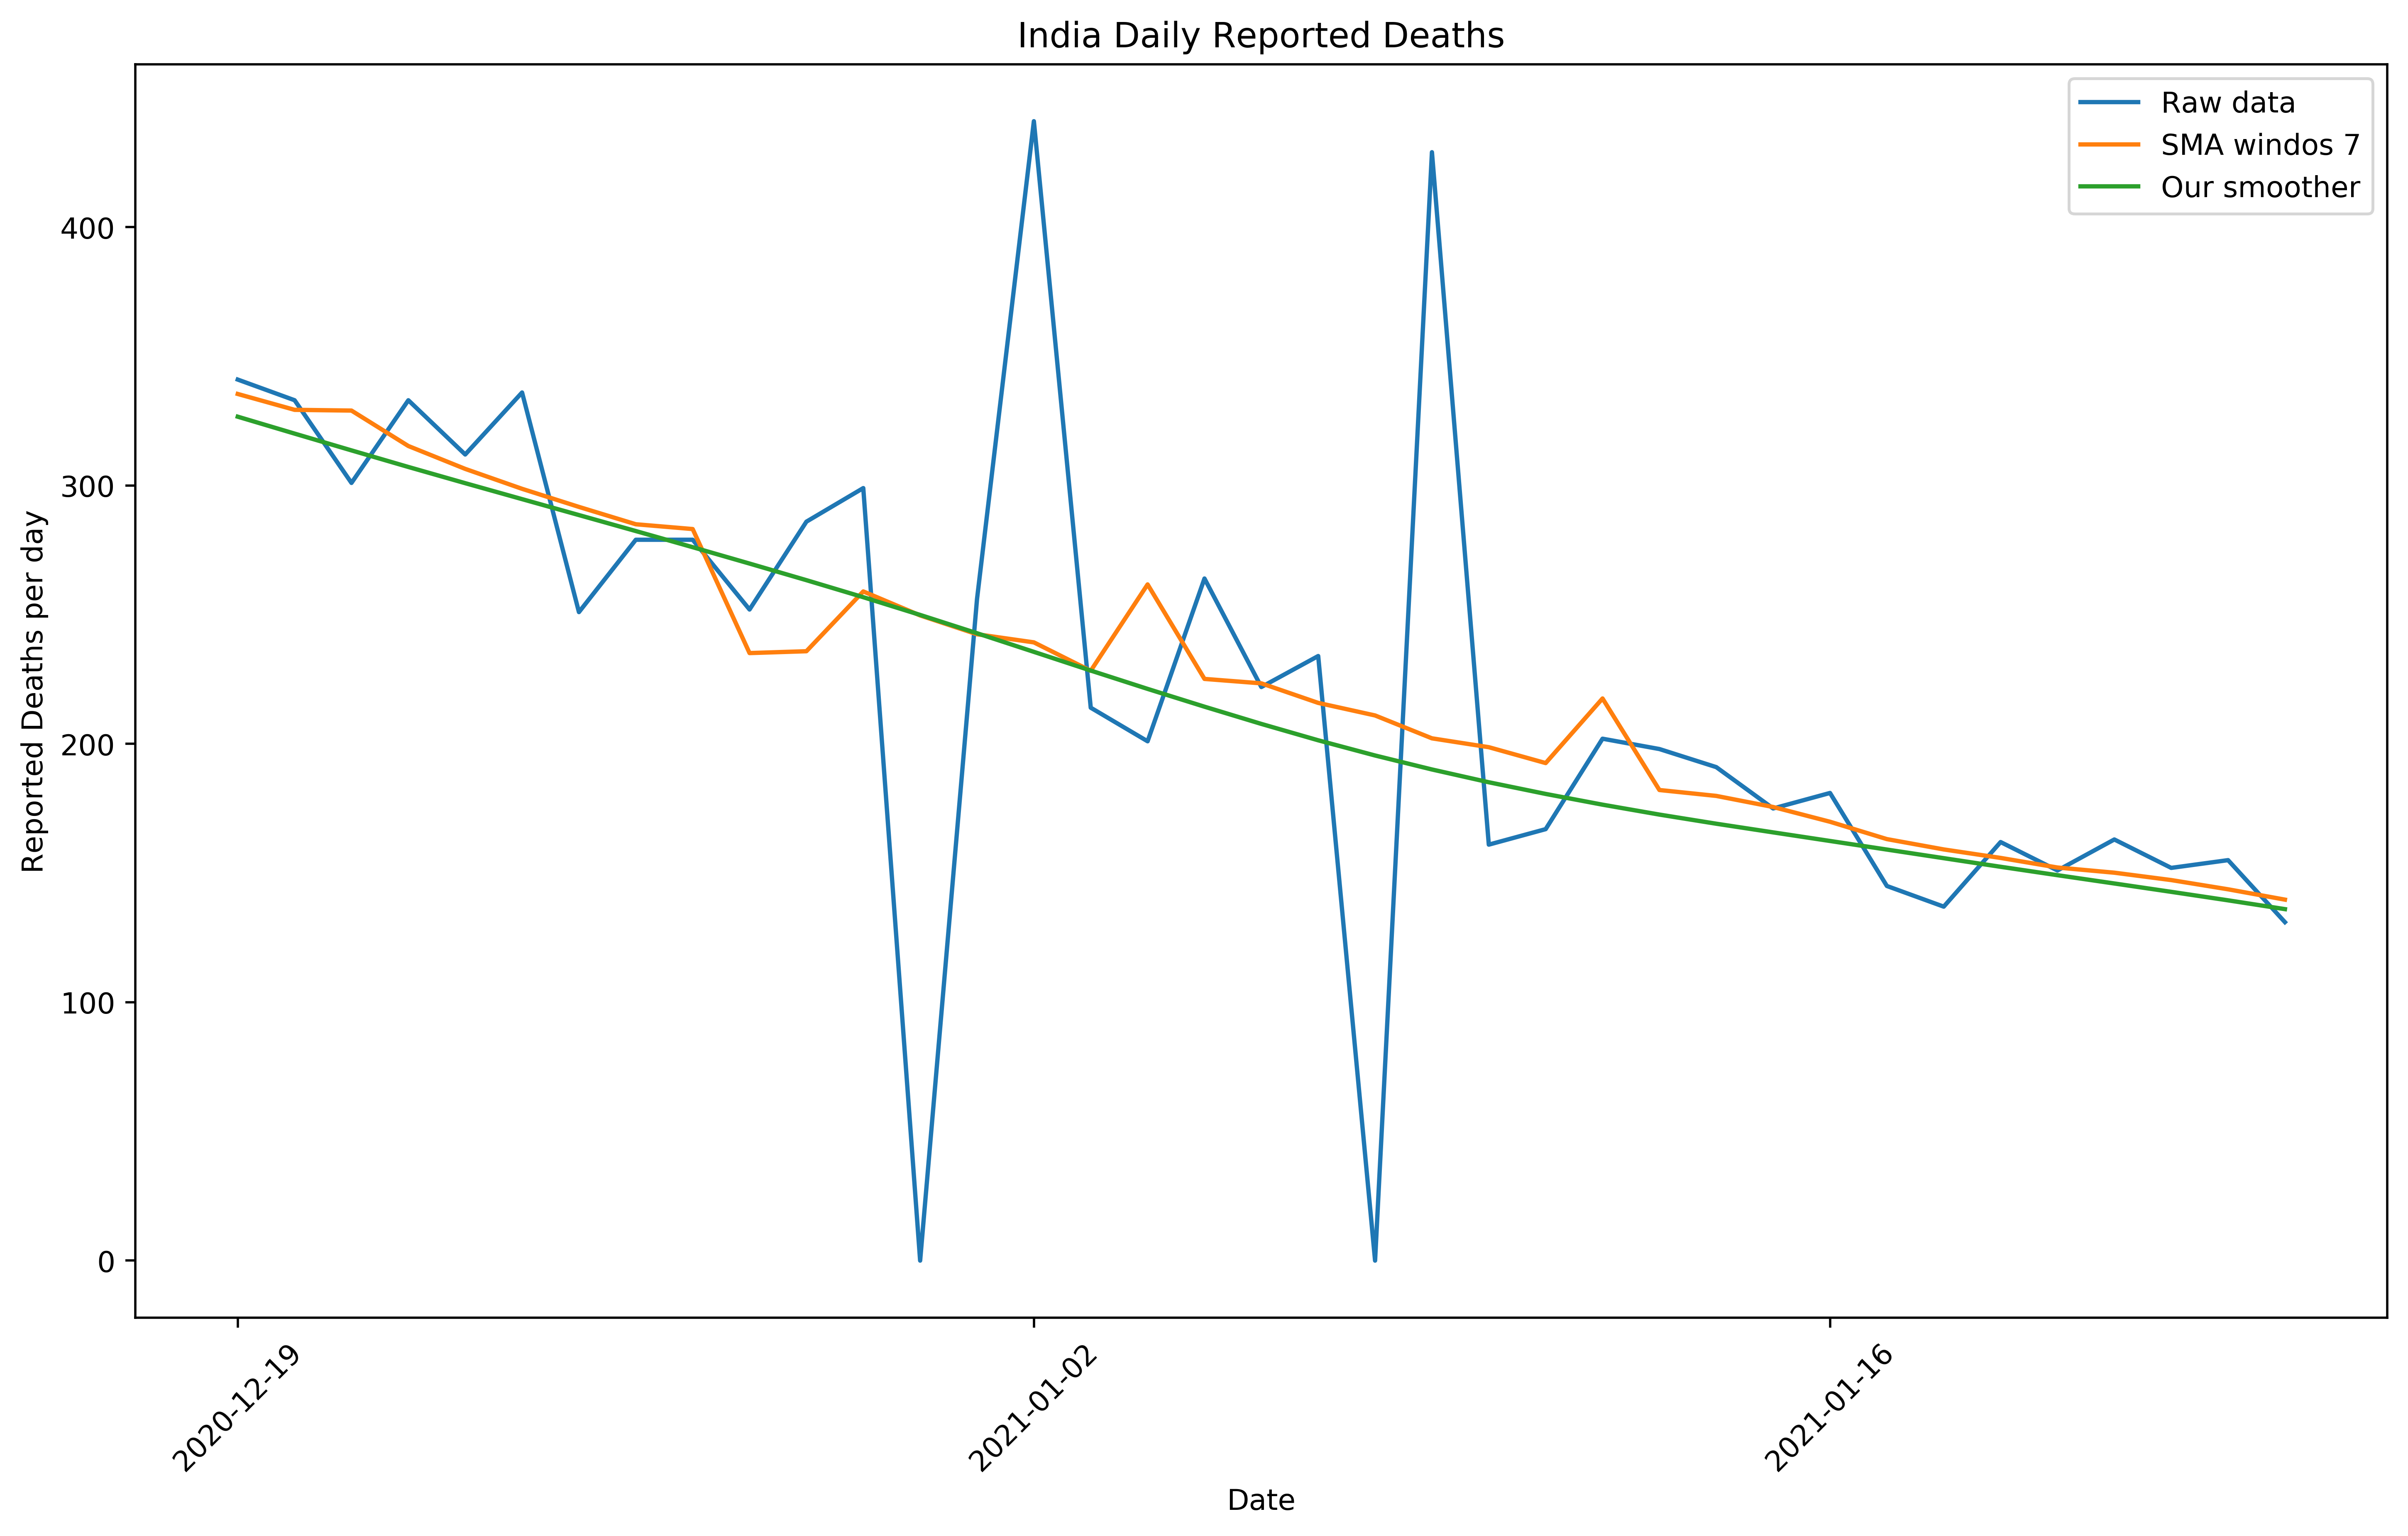

In [12]:
figure(figsize=(14, 8),dpi=500)

plt.plot(India_dates[283:320],India_death_array[283:320],label='Raw data')
plt.plot(India_dates[283:320],India_death_array_7[283:320],label='SMA windos 7')
plt.plot(India_dates[283:320],smoothed_curve[283:320],label='Our smoother')

plt.arrow(295, 610, 0, -100, width = 1,head_width = 2, head_length= 35, ec ='red')
plt.arrow(297,610, 0, -100, width = 1,head_width = 2, head_length= 35,ec ='red')

plt.arrow(303, 610, 0, -100, width = 1,head_width = 2, head_length= 35, ec ='red')
plt.arrow(305,610, 0, -100, width = 1,head_width = 2, head_length= 35,ec ='red')

plt.legend()
ax = plt.gca()
plt.xticks(rotation = 45)
plt.title('India Daily Reported Deaths')
plt.xlabel('Date')
plt.ylabel('Reported Deaths per day')
ax.set_xticks(ax.get_xticks()[::14]);
plt.savefig('ZigZagZoomed.png')

The seven-day SMA smoothed curve is reacting to the zig-zag behavior. However, notice the VA smoothed curve. It is going right at the center of the zig-zag line. 
***
As mentioned in the first paragraph, another issue we observed in COVID-19 data is quasi-periodicity. In other words, there is no apparent periodicity. The following section demonstrates the advantages of the VA smoother over the SMA, for quasi-periodicity noises. We start with loading a set of simulated SIR curves. 

In [13]:
simulated_df = pd.read_csv("DifferentPeriodic.csv")
Seven_day_modulated = simulated_df['Seven_day_modulated'].to_numpy()
Fourteen_day_modulated = simulated_df['Fourteen_day_modulated'].to_numpy()
Different_day_modulated = simulated_df['Different_day_modulated'].to_numpy()
Time = simulated_df['Time'].to_numpy()

We simulated a SIR curve and added white noise. Then created three data sets by adding extra periodic noises with different periodicities. 

* Data set 1: Added a periodic noise with a 7-day periodicity.
* Data set 2:  Added a periodic noise with a 14-day periodicity.
* Data set 3: Added a periodic noise with a changing periodicity. The periodicity starts with 7 days, then 14 days, and finally the periodicity goes to 21 days. 

The following graphs show these three data sets. 

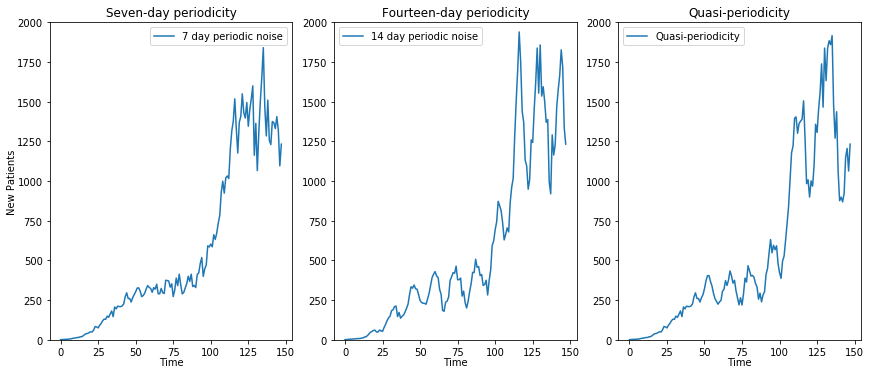

In [14]:

fig, axs = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(12)

fig.tight_layout()


axs[0].plot(Time, Seven_day_modulated, label='7 day periodic noise')
axs[0].set_xlabel('Time',labelpad=0)
axs[0].set_ylabel('New Patients',labelpad=0)
axs[0].title.set_text('Seven-day periodicity')
axs[0].legend()
axs[0].set_ylim([0, 2000])

axs[1].plot(Time, Fourteen_day_modulated, label='14 day periodic noise')
axs[1].set_xlabel('Time',labelpad=0)
axs[1].title.set_text('Fourteen-day periodicity')
axs[1].legend()
axs[1].set_ylim([0, 2000])

axs[2].plot(Time, Different_day_modulated, label='Quasi-periodicity')
axs[2].set_xlabel('Time',labelpad=0)
axs[2].title.set_text('Quasi-periodicity')
axs[2].legend()
axs[2].set_ylim([0, 2000]);

plt.savefig('Quasi-Periodicity-Simulated.png')

The state-of-the-art method to remove the noise is to select Simple Moving Average (SMA) with window size equal to the periodicity. In the following graphs, we chose the simulated curves with a 7 and 14 day periodicities. Then we smoothed the curve with SMA window 7 and 14.

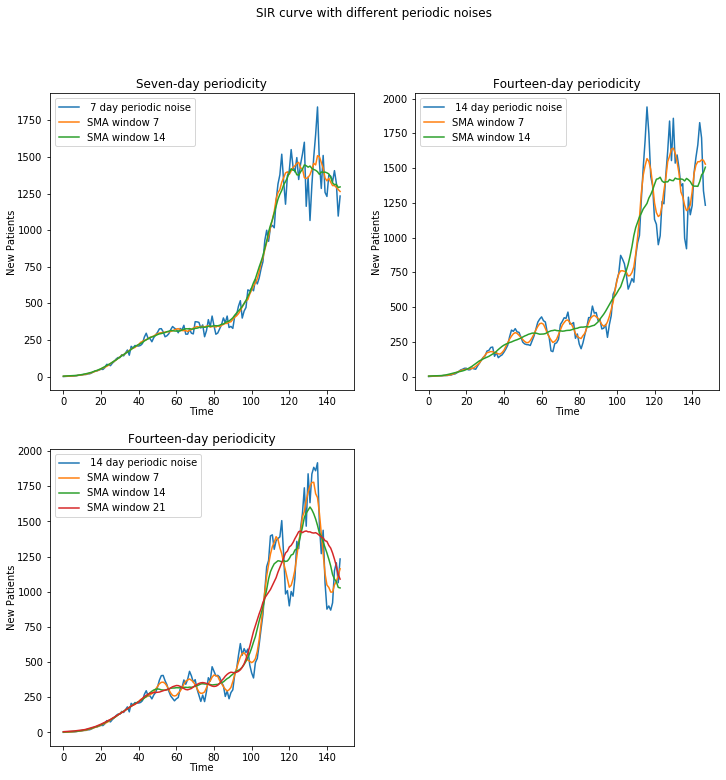

In [15]:

fig, axs = plt.subplots(2,2)
fig.set_figheight(12)
fig.set_figwidth(12)

fig.suptitle('SIR curve with different periodic noises')
axs[0,0].plot(Time, Seven_day_modulated, label=' 7 day periodic noise')
axs[0,0].plot(Time, simple_moving_average(Seven_day_modulated,7), label='SMA window 7')
axs[0,0].plot(Time, simple_moving_average(Seven_day_modulated,14), label='SMA window 14')
axs[0,0].set_xlabel('Time',labelpad=0)
axs[0,0].set_ylabel('New Patients',labelpad=0)
axs[0,0].title.set_text('Seven-day periodicity')
axs[0,0].legend()

axs[0,1].plot(Time, Fourteen_day_modulated, label=' 14 day periodic noise')
axs[0,1].plot(Time, simple_moving_average(Fourteen_day_modulated,7), label='SMA window 7')
axs[0,1].plot(Time, simple_moving_average(Fourteen_day_modulated,14), label='SMA window 14')
axs[0,1].set_xlabel('Time',labelpad=0)
axs[0,1].set_ylabel('New Patients',labelpad=0)
axs[0,1].title.set_text('Fourteen-day periodicity')
axs[0,1].legend();

axs[1,0].plot(Time, Different_day_modulated, label=' 14 day periodic noise')
axs[1,0].plot(Time, simple_moving_average(Different_day_modulated,7), label='SMA window 7')
axs[1,0].plot(Time, simple_moving_average(Different_day_modulated,14), label='SMA window 14')
axs[1,0].plot(Time, simple_moving_average(Different_day_modulated,21), label='SMA window 21')
axs[1,0].set_xlabel('Time',labelpad=0)
axs[1,0].set_ylabel('New Patients',labelpad=0)
axs[1,0].title.set_text('Fourteen-day periodicity')
axs[1,0].legend();

axs[1,1].axis('off');
plt.savefig('Quasiperiodicity_SMA_Smoothed.png')

In the top-left figure, the smooth line goes at the center of the curve until the 120th day. After that, when noise amplitude becomes higher, the SMA smoother curve starts oscillating. So after the 120th day, SMA window 14 gives a better-smoothed curve. In the top-right figure, SMA window 14 provides the best result. The bottom-left figure is for the data set with a quasi-periodicity. None of the smoothed curves give a smoothed curve that goes at the center of the noisy data. Let's take a look at how VA smoother works with these data sets.

In [16]:
VASmooth_Simulated = VAS.VASmoother()
#Lets smooth to a smoothness up to the wned of the whisker
VASmooth_Simulated.curvature_threshold_1 = 1e-4#np.quantile(R_t_Theoretical_Curve_dd**2, 0.25)
VASmooth_Simulated.mirror_padding_length = 0

index_included, index_excluded = VASmooth_Simulated.seperate_outlier_curvatures(Seven_day_modulated, 21, 1, 0)
kz_window,kz_itr,VASmoothed_Seven_day_modulated_curve,curvature_arr,smoothing_mods = VASmooth_Simulated.run_va_smoother(Seven_day_modulated,0,index_included)

index_included, index_excluded = VASmooth_Simulated.seperate_outlier_curvatures(Fourteen_day_modulated, 21, 1, 0)
kz_window,kz_itr,VASmoothed_Fourteen_day_modulated_curve,curvature_arr,smoothing_mods = VASmooth_Simulated.run_va_smoother(Fourteen_day_modulated,0,index_included)




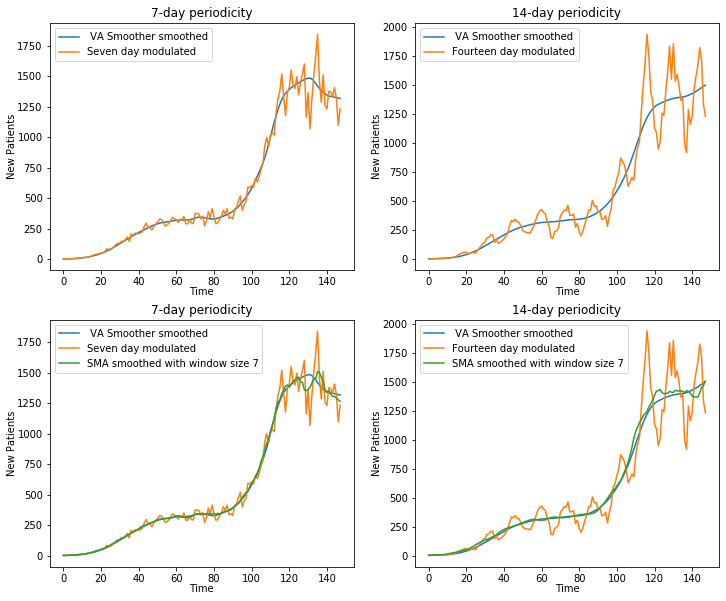

In [17]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(12)


axs[0,0].plot(Time, VASmoothed_Seven_day_modulated_curve, label=' VA Smoother smoothed')
axs[0,0].plot(Time, Seven_day_modulated, label="Seven day modulated")
axs[0,0].set_xlabel('Time',labelpad=0)
axs[0,0].set_ylabel('New Patients',labelpad=0)
axs[0,0].title.set_text('7-day periodicity')
axs[0,0].legend()

axs[0,1].plot(Time, VASmoothed_Fourteen_day_modulated_curve, label=' VA Smoother smoothed')
axs[0,1].plot(Time, Fourteen_day_modulated, label="Fourteen day modulated")
axs[0,1].set_xlabel('Time',labelpad=0)
axs[0,1].set_ylabel('New Patients',labelpad=0)
axs[0,1].title.set_text('14-day periodicity')
axs[0,1].legend()

axs[1,0].plot(Time, VASmoothed_Seven_day_modulated_curve, label=' VA Smoother smoothed')
axs[1,0].plot(Time, Seven_day_modulated, label="Seven day modulated")
axs[1,0].plot(Time, simple_moving_average(Seven_day_modulated,7), label='SMA smoothed with window size 7')

axs[1,0].set_xlabel('Time',labelpad=0)
axs[1,0].set_ylabel('New Patients',labelpad=0)
axs[1,0].title.set_text('7-day periodicity')
axs[1,0].legend()

axs[1,1].plot(Time, VASmoothed_Fourteen_day_modulated_curve, label=' VA Smoother smoothed')
axs[1,1].plot(Time, Fourteen_day_modulated, label="Fourteen day modulated")
axs[1,1].plot(Time, simple_moving_average(Fourteen_day_modulated,14), label='SMA smoothed with window size 7')
axs[1,1].set_xlabel('Time',labelpad=0)
axs[1,1].set_ylabel('New Patients',labelpad=0)
axs[1,1].title.set_text('14-day periodicity')
axs[1,1].legend();

plt.savefig('Quasiperiodicity_VA_Smoothed.png')

Now you could see that the VA smoother creates a smooth curve at the center of noisy data. The user does not have to worry about guessing the periodicity of the noise. Another advantage of the VA smoother is, the user has to pass only one mandatory hyperparameter. That hyperparameter is the desired smoothness of the curve. Then the VA smoother algorithm automatically determines how much to smooth the input data. 
***
Let's take a look at how the VA smoother works when the noice has a quasi-periodicity. 

In [18]:
index_included, index_excluded = VASmooth_Simulated.seperate_outlier_curvatures(Different_day_modulated, 21, 1, 0)
kz_window,kz_itr,VASmoothed_Multiple_modulation_curve,curvature_arr,smoothing_mods = VASmooth_Simulated.run_va_smoother(Different_day_modulated,0,index_included)


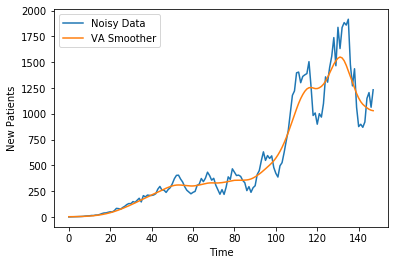

In [19]:
plt.plot(Time,Different_day_modulated,label='Noisy Data')
plt.plot(Time,VASmoothed_Multiple_modulation_curve,label='VA Smoother')
plt.xlabel('Time')
plt.ylabel('New Patients')
plt.legend();
plt.savefig('QuasiPeriodicity_End_21_small_Smooth.png')

Now you can see that VA smoother is responding to the 21-day periodicity. However, it maintains the desired smoothness given as a hyper parameter. If you want to reduce the rate, how the smoother respond to 21-day periodicity. The user could reduce the hyperparameter we pass. 

In [20]:
VASmooth_Simulated.curvature_threshold_1 = 5e-5
index_included, index_excluded = VASmooth_Simulated.seperate_outlier_curvatures(Different_day_modulated, 21, 1, 0)
kz_window,kz_itr,VASmoothed_Multiple_modulation_curve_over_smoothed,curvature_arr,smoothing_mods = VASmooth_Simulated.run_va_smoother(Different_day_modulated,0,index_included)


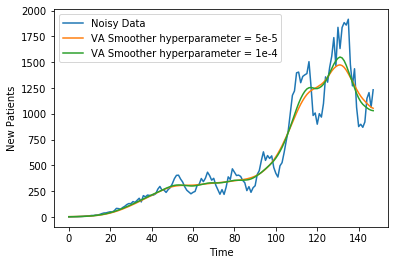

In [21]:
plt.plot(Time,Different_day_modulated,label='Noisy Data')
plt.plot(Time,VASmoothed_Multiple_modulation_curve_over_smoothed,label='VA Smoother hyperparameter = 5e-5')
plt.plot(Time,VASmoothed_Multiple_modulation_curve,label='VA Smoother hyperparameter = 1e-4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('New Patients')
plt.savefig('QuasiPeriodicity_End_21_large_Smooth.png')